## Imports and Configurations

In [4]:
import os.path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import random
import scipy.misc
import time
import shutil
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Lambda
from keras.layers.core import Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


In [5]:
# Configurations here

flags = {
    'train_model': True,
    'show_plots': False,
    'show_images': False,
    'dropout': 0.25
}


## Load and Preprocess Data

#### Data Augmentation and Balancing

In [6]:
def augment_brightness(image):
    # Randomly select a percentage change
    random_bright = 0.25 + np.random.uniform()
    
    # Change to HSV to change the brightness V
    image_augmented = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_augmented[:,:,2] = image_augmented[:,:,2]*random_bright
    
    # Convert back to RGB
    image_augmented = cv2.cvtColor(image_augmented,cv2.COLOR_HSV2RGB)
    return image_augmented

def mirror_image(image, angle):
    image_mirrored = cv2.flip(image,1)
    angle = -angle
    return image_mirrored, angle

def perturb_angle(angle):
    new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
    return new_angle

def augment_image(image, angle):
    mirror = bool(random.randint(0,1))
    perturb = bool(random.randint(0,1))
    brighten = bool(random.randint(0,1))
    
    if mirror:
        image, angle = mirror_image(image, angle)
    if perturb:
        angle = perturb_angle(angle)
    if brighten:
        image = augment_brightness(image)
        
    return image, angle

#### Load Data

In [9]:
df_udacity = pd.read_csv('data/udacity_data/driving_log.csv')
df.tail()

,center,left,right,steering,throttle,brake,speed
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


#### Plots

In [12]:
if flags['show_plots']:
    plt.figure(figsize=(16,5))
    plt.plot(df['steering'].values[0:1000])

In [13]:
if flags['show_images']:
    for i in range(3):
        index = np.random.choice(df_udacity.index)
        filename = 'data/udacity_data/' + df_udacity['center'][index]
        image = mpimg.imread(filename)
        plt.figure()
        plt.imshow(image)

## Setup and Train Network

#### Data Generator

In [89]:
steering_values = []

def train_generator(df):
    binned =  np.digitize(df['steering'].values, np.arange(-1, 1, 0.1))
    binned_indexes = []
    for i in range(21):
        binned_indexes.append([j for j,v in enumerate(binned) if v == i])
    valid_bins = [i for i,v in enumerate(binned_indexes) if len(v) > 0]
    valid_bins += [11]
    
    while True:
        images = []
        angles = []
        for i in range(128):
            bin = np.random.choice(valid_bins)
            index = np.random.choice(binned_indexes[bin])
            row = df.loc[index]
            camera = bool(random.randint(0,3))
            if camera == 0:
                filename = row['left'].strip()
                angle = row['steering'] + 0.25
            elif camera in (1,2):
                filename = row['center'].strip()
                angle = row['steering']
            elif camera == 3:
                filename = row['right'].strip()
                angle = row['steering'] - 0.25
            
            if '2017_02_16' in filename:
                filename = 'data/my_driving_data/' + filename
            else:
                filename = 'data/udacity_data/' + filename
            image = mpimg.imread(filename)

            augment = random.random() > 0.5
            if augment:
                image, angle = augment_image(image, angle)
            if abs(angle) > 1.0:
                angle = angle / abs(angle)
                
            image = cv2.resize(image, (200, 66))
            image = image[np.newaxis, ...]
            images.append(image)
            angles.append(angle)
            
        global steering_values
        steering_values += angles
        batch_x = np.concatenate(images, axis=0)
        batch_y = np.array(angles)
        yield batch_x, batch_y

#### Model and Training

In [90]:
model = Sequential()

model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(66, 200, 3)))

model.add(Convolution2D(24, 5, 5, subsample=(2,2), init='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, subsample=(2,2), init='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(2,2), init='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, init='he_normal'))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(flags['dropout']))

model.add(Flatten())
model.add(Dense(1164, init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(flags['dropout']))

model.add(Dense(100, init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(flags['dropout']))

model.add(Dense(50, init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(flags['dropout']))

model.add(Dense(10, init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(flags['dropout']))

model.add(Dense(1, init='he_normal'))

In [93]:
if flags['train_model']:
    start = time.time()
    steering_values = []
    adam = Adam()
    model.compile(loss='mse', optimizer=adam)
    model.fit_generator(train_generator(df_udacity), samples_per_epoch=32000, 
                        nb_epoch=10, validation_data=train_generator(df_udacity), nb_val_samples=7936)
    model.save('model.h5')
    end = time.time()
    print("Training Time (s)", end - start)

Epoch 1/10
32000/32000 [==============================] - 95s - loss: 0.0290 - val_loss: 0.0085
Epoch 2/10
32000/32000 [==============================] - 91s - loss: 0.0287 - val_loss: 0.0115
Epoch 3/10
32000/32000 [==============================] - 92s - loss: 0.0287 - val_loss: 0.0123
Epoch 4/10
32000/32000 [==============================] - 91s - loss: 0.0281 - val_loss: 0.0113
Epoch 5/10
32000/32000 [==============================] - 91s - loss: 0.0280 - val_loss: 0.0114
Epoch 6/10
32000/32000 [==============================] - 92s - loss: 0.0276 - val_loss: 0.0071
Epoch 7/10
32000/32000 [==============================] - 92s - loss: 0.0278 - val_loss: 0.0071
Epoch 8/10
32000/32000 [==============================] - 91s - loss: 0.0268 - val_loss: 0.0072
Epoch 9/10
32000/32000 [==============================] - 92s - loss: 0.0323 - val_loss: 0.0093
Epoch 10/10
32000/32000 [==============================] - 91s - loss: 0.0271 - val_loss: 0.0105
Training Time (s) 925.567773103714


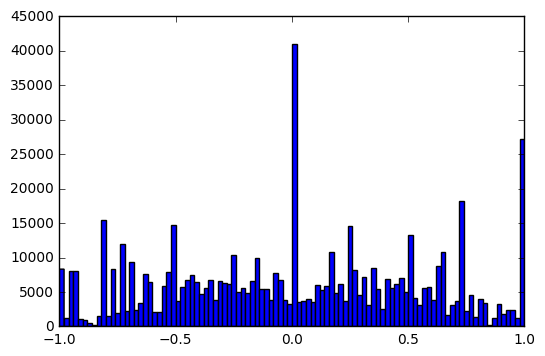

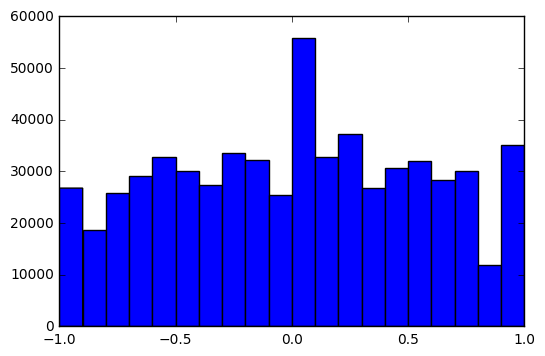

In [92]:
plt.hist(steering_values, bins=100)
plt.figure()
plt.hist(steering_values, bins=20)
pass